In [115]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from  sklearn.metrics import classification_report,confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

In [116]:
NUM_CLASSES = 4
NUM_SAMPLES = 1000
NUM_FEATURES = 2
RANDOM_SEED = 42
NOISE = 0.02

X,Y = make_blobs(n_samples=NUM_SAMPLES,n_features=NUM_FEATURES,
                 cluster_std=2, centers= NUM_CLASSES, random_state=RANDOM_SEED)

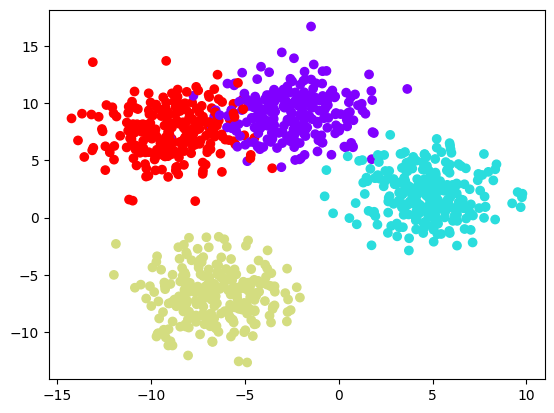

In [117]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap="rainbow")

In [118]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.LongTensor)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [119]:
class MultiClassClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.stacked_layer = nn.Sequential(
        nn.Linear(in_features=2,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=4)
    )


  def forward(self,x:torch.Tensor):
    return self.stacked_layer(x)

In [120]:
model = MultiClassClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)

In [121]:
y_logits = model(X_test)

In [122]:
y_logits[:5]

tensor([[-0.1192, -0.4379, -0.2367, -0.1580],
        [-0.3910, -0.8368, -0.4998,  0.4402],
        [-0.3084, -0.6055, -0.4477,  0.1717],
        [-1.4647,  0.0371, -0.5774, -0.7557],
        [-0.0038, -0.7251, -0.3682, -0.0700]], grad_fn=<SliceBackward0>)

In [123]:
y_pred_probs = torch.softmax(y_logits,dim=1)

In [124]:
y_pred_probs[:5]

tensor([[0.2795, 0.2032, 0.2485, 0.2688],
        [0.2069, 0.1325, 0.1856, 0.4750],
        [0.2365, 0.1757, 0.2057, 0.3822],
        [0.1005, 0.4512, 0.2441, 0.2042],
        [0.3208, 0.1560, 0.2229, 0.3003]], grad_fn=<SliceBackward0>)

In [125]:
y_preds = torch.argmax(y_pred_probs,dim=1)

In [126]:
y_preds[:5]

tensor([0, 3, 3, 1, 0])

In [127]:
torch.manual_seed(RANDOM_SEED)

epochs = 701

train_loss = []
test_loss = []

for epoch in range(epochs):

  # move model to training mode
  model.train()

  # forward pass
  logits_train = model(X_train)
  pred_train = torch.argmax(torch.softmax(logits_train,dim=1),dim=1)

  # loss
  loss_train = loss_fn(logits_train,Y_train)
  train_loss.append(loss_train.item())

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss_train.backward()

  # optimizer step
  optimizer.step()

  if epoch%50 ==0:
    model.eval()
    with torch.inference_mode():
      logits_test = model(X_test)
      pred_test = torch.argmax(torch.softmax(logits_test,dim=1),dim=1)

      loss_test = loss_fn(logits_test,Y_test)
      test_loss.append(loss_test.item())
      print(f"epoch:{epoch}  train_loss:{loss_train}  test_loss:{loss_test}")

epoch:0  train_loss:1.4304171800613403  test_loss:1.3982082605361938
epoch:50  train_loss:0.9780070781707764  test_loss:0.9633071422576904
epoch:100  train_loss:0.7492827773094177  test_loss:0.7464002966880798
epoch:150  train_loss:0.6010901927947998  test_loss:0.6063917875289917
epoch:200  train_loss:0.4973548650741577  test_loss:0.5083075165748596
epoch:250  train_loss:0.42270660400390625  test_loss:0.4377329647541046
epoch:300  train_loss:0.3675207495689392  test_loss:0.3856923282146454
epoch:350  train_loss:0.32557055354118347  test_loss:0.3461659550666809
epoch:400  train_loss:0.2927367687225342  test_loss:0.31540152430534363
epoch:450  train_loss:0.26668626070022583  test_loss:0.29121312499046326
epoch:500  train_loss:0.24568521976470947  test_loss:0.27182140946388245
epoch:550  train_loss:0.22844922542572021  test_loss:0.2560478448867798
epoch:600  train_loss:0.21413421630859375  test_loss:0.24303948879241943
epoch:650  train_loss:0.20205478370189667  test_loss:0.232154443860054

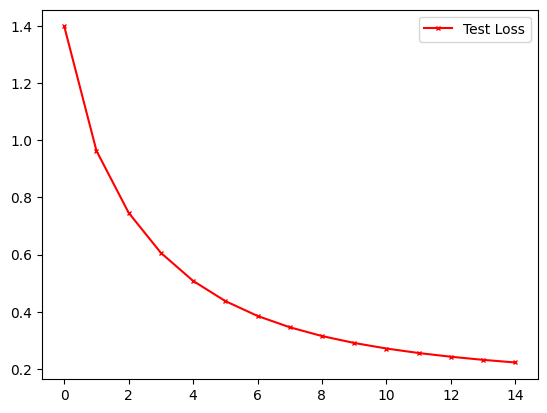

In [128]:
plt.plot(range(len(test_loss)),test_loss,c="r",label = "Test Loss",marker="x",markerfacecolor='black', markersize=3)
plt.legend()

In [129]:
model.eval()
with torch.inference_mode():
  pred = torch.argmax(torch.softmax(model(X_test),dim=1),dim=1)

In [130]:
print(classification_report(Y_test,pred))
print(confusion_matrix(Y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87        50
           1       0.98      0.98      0.98        48
           2       1.00      1.00      1.00        48
           3       0.88      0.93      0.90        54

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.93       200

[[42  1  0  7]
 [ 1 47  0  0]
 [ 0  0 48  0]
 [ 4  0  0 50]]
